In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from geopy import distance
from geopy import geocoders
from geopy.geocoders import GoogleV3

In [133]:
df = pd.read_csv('Boston_Marathon_Results2006.csv')

df['division'] = [x.split('/') for x in df['division']]
df['division_place'] = [int(x[0]) for x in df['division']]
df['division_num'] = [int(x[1]) for x in df['division']]
df['div_perc'] = 1 - df['division_place'] / df['division_num']

df['genderdiv'] = [x.split('/') for x in df['genderdiv']]
df['genderdiv_place'] = [int(x[0]) for x in df['genderdiv']]
df['genderdiv_num'] = [int(x[1]) for x in df['genderdiv']]
df['gender_perc'] = 1 - df['genderdiv_place'] / df['genderdiv_num']

df['overall'] = [x.split('/') for x in df['overall']]
df['overall_place'] = [int(x[0]) for x in df['overall']]
df['overall_num'] = [int(x[1]) for x in df['overall']]
df['overall_perc'] = 1 - df['overall_place'] / df['overall_num']

df['gender'] = np.where(df['gender'] == 'M', 1, 0)

#df['location'] = [df['city'] + ', ' + df['state'] + ' ' + df['country'] for x in df['country']]


In [134]:
df['location'] = df['city'] + ', ' + df['state'] + ' ' + df['country']
df['location'] = df['location'].replace(np.NAN, df['city'] + ' ' + df['country'])

locations['lat'] = np.nan
locations['long'] = np.nan

In [17]:
locations = pd.DataFrame(df['location'].unique(), columns=['name'])
locations.head()

,name
0,Paarl RSA
1,Ehime JPN
2,Nairobi KEN
3,"Cobble Hill, BC CAN"
4,Jurmala LAT


In [6]:
df.head()

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,division_place,division_num,div_perc,genderdiv_place,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location
0,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,1,20,0.950000,1,23,0.956522,1,27,0.962963,NaN
1,"[3 , 4372]","Tosa, Reiko",Ehime,0,29,144.18,F1,"[26 , 19682]",NaN,"[3 , 7621]",...,3,4372,0.999314,3,7621,0.999606,26,19682,0.998679,NaN
2,"[9 , 4401]","Onsare, Wilson",Nairobi,1,29,133.78,2,"[9 , 19682]",NaN,"[9 , 12061]",...,9,4401,0.997955,9,12061,0.999254,9,19682,0.999543,NaN
3,"[4 , 20]","Bergman, Alan J.",Cobble Hill,1,32,89.93,W2,"[4 , 27]",BC,"[4 , 23]",...,4,20,0.800000,4,23,0.826087,4,27,0.851852,"Cobble Hill, BC CAN"
4,"[2 , 4372]","Prokopcuka, Jelena",Jurmala,0,29,143.80,F2,"[25 , 19682]",NaN,"[2 , 7621]",...,2,4372,0.999543,2,7621,0.999738,25,19682,0.998730,NaN


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19784 entries, 0 to 19840
Data columns (total 26 columns):
division           19784 non-null object
name_x             19784 non-null object
city               19784 non-null object
gender             19784 non-null int64
age                19784 non-null int64
official           19784 non-null float64
bib                19784 non-null object
overall            19784 non-null object
state              18712 non-null object
genderdiv          19784 non-null object
net                0 non-null float64
country            19784 non-null object
division_place     19784 non-null int64
division_num       19784 non-null int64
div_perc           19784 non-null float64
genderdiv_place    19784 non-null int64
genderdiv_num      19784 non-null int64
gender_perc        19784 non-null float64
overall_place      19784 non-null int64
overall_num        19784 non-null int64
overall_perc       19784 non-null float64
location           19784 non-null obj

In [140]:
# Just for fun, my results
df[df['name'] == 'Schuil, Crystal J.']

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location,place_name,lat,long,distance
19393,"[3819 , 4372]","Schuil, Crystal J.",Cambridge,0,20,276.47,23071,"[17397 , 19682]",MA,"[6540 , 7621]",...,7621,0.141845,17397,19682,0.116096,"Cambridge, MA USA","Cambridge, MA USA",42.373616,-71.109733,2.828987


Hmmm, I remember being faster :-)  At least I finished?

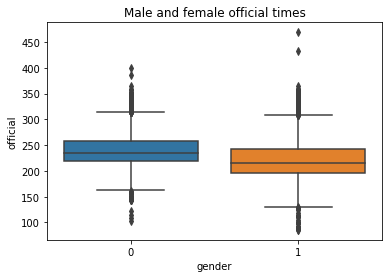

In [141]:
sns.boxplot(x='gender', y='official', data=df)
plt.title('Male and female official times')
plt.show()

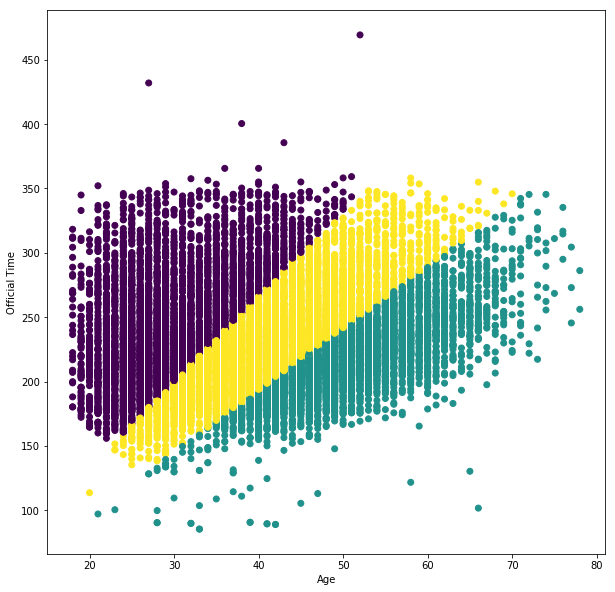

In [197]:
# Leave out categorical features for now
features = ['gender', 'age', 'official', 'overall_perc', 'div_perc']

X = df[features]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values
y_pred = KMeans(n_clusters=3).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X['age'], X['official'], c=y_pred)
plt.ylabel('Official Time')
plt.xlabel('Age')
plt.show()

In [208]:
rs = ShuffleSplit(n_splits=2, test_size=0.5)
splits = list(rs.split(X_norm))
X1 = X_norm[splits[0][0]]
X2 = X_norm[splits[0][1]]
X3 = X_norm[splits[1][0]]
X4 = X_norm[splits[1][1]]

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5698170918919631
0.5656722233080241
0.5679267634494539
0.5675600930314298


# Mean-shift

Number of estimated clusters: 9


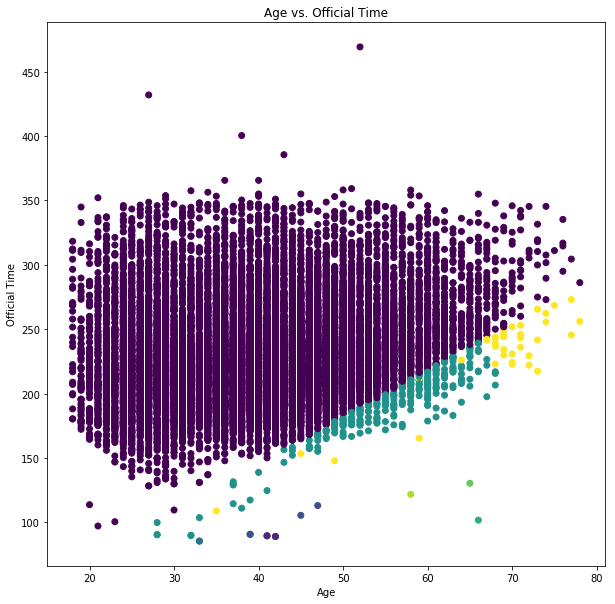

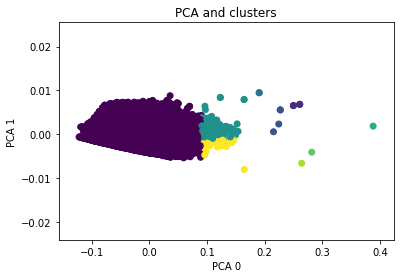

In [210]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm, quantile=0.1, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
fig = plt.figure(figsize=(10, 10))
plt.scatter(X['age'], X['official'], c=labels)
plt.ylabel('Official Time')
plt.xlabel('Age')
plt.title('Age vs. Official Time')
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.title('PCA and clusters')
plt.show()


In [211]:
# Use same splits as for Kmeans
for sample in [X1, X2, X3, X4]:
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

-0.00029891178934031356
0.0005059524534202428
0.0001765491551965405
0.5675600930314298


# Add in some latitude and longitude
Locations defined near top of file

In [57]:
# Do not save to github with api_key
geolocator = GoogleV3(api_key='Insert API Key Here')

#create an input address string
#you can also build this by reading from an input database and building a string
locations['latlong'] = np.nan

def find_lat_long(place):
    
    inputAddress = place
    
    #do the geocode
    location = geolocator.geocode(inputAddress, timeout=10)

    if location is None:
        return np.nan
    else:
        # Do not technically need to write to a csv, but this took a long time to run, and this 
        # saves the progress and makes it easier to load back in without running again
        with open('locations_file.csv','a') as fd:
            fd.write(place + ' ' + ' / ' + str(location.latitude) + ' / ' + str(location.longitude) + '\n')
        return str(location.latitude) + ', ' + str(location.longitude)
    

In [ ]:
locations['latlong']= locations.apply(lambda x: find_lat_long(x['name']), axis=1)

In [62]:
locations[locations['latlong'].isna()==True]

,name,lat,long,latlong
5,Keiyo KEN,NaN,NaN,NaN
24,Sidamo ETH,NaN,NaN,NaN
284,Santiago DOM,NaN,NaN,NaN
354,George Town CAY,NaN,NaN,NaN
587,Moyen FRA,NaN,NaN,NaN
1520,"Naughton, ON CAN",NaN,NaN,NaN
1962,La Libertad ESA,NaN,NaN,NaN
2007,"Taipei County , Taiwan TPE",NaN,NaN,NaN
2161,"Brighton, ON CAN",NaN,NaN,NaN
2741,Antony FRA,NaN,NaN,NaN


In [212]:
# Resaved locations file as locations_csv, loaded back in
lat_long = pd.read_csv('locations_csv.csv', names=['place_name', 'lat', 'long'], header=0)
lat_long['place_name'] = lat_long['place_name'].str.strip()

In [213]:
boston_lat = 42.361145
boston_long = -71.057083

# Used to measure how far cities are from Boston
def boston_distance(lat, long):
    # default Geopy uses geodesic distance
    try:
        dist = distance.distance((boston_lat, boston_long), (lat, long)).miles
        return dist
    except:
        return np.nan

In [214]:
lat_long['distance']= lat_long.apply(lambda x: boston_distance(x['lat'], x['long']), axis=1)

In [215]:
df = df.merge(lat_long, left_on='location', right_on='place_name', how='left')
df.head()

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,overall_perc,location,place_name_x,lat_x,long_x,distance_x,place_name_y,lat_y,long_y,distance_y
0,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455,Paarl RSA,-33.734230,18.962109,7729.026455
1,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455,Paarl RSA,-33.734230,18.962109,7729.026455
2,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455,Paarl RSA,-33.734230,18.962109,7729.026455
3,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455,Paarl RSA,-33.734230,18.962109,7729.026455
4,"[3 , 4372]","Tosa, Reiko",Ehime,0,29,144.18,F1,"[26 , 19682]",NaN,"[3 , 7621]",...,0.998679,Ehime JPN,Ehime JPN,33.841624,132.765681,6974.799964,Ehime JPN,33.841624,132.765681,6974.799964


In [216]:
#57 records without distance, could try maps, but going to drop
df = df.dropna(subset=['lat', 'long', 'distance'], axis=0)

KeyError: ['lat', 'long', 'distance']

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19784 entries, 0 to 19840
Data columns (total 26 columns):
division           19784 non-null object
name               19784 non-null object
city               19784 non-null object
gender             19784 non-null int64
age                19784 non-null int64
official           19784 non-null float64
bib                19784 non-null object
overall            19784 non-null object
state              18712 non-null object
genderdiv          19784 non-null object
net                0 non-null float64
country            19784 non-null object
division_place     19784 non-null int64
division_num       19784 non-null int64
div_perc           19784 non-null float64
genderdiv_place    19784 non-null int64
genderdiv_num      19784 non-null int64
gender_perc        19784 non-null float64
overall_place      19784 non-null int64
overall_num        19784 non-null int64
overall_perc       19784 non-null float64
location           19784 non-null obj

In [116]:
lat_long.iloc[0]

level_0               0
index                 0
name        Paarl RSA  
lat            -33.7342
long            18.9621
distance        7729.03
Name: 0, dtype: object

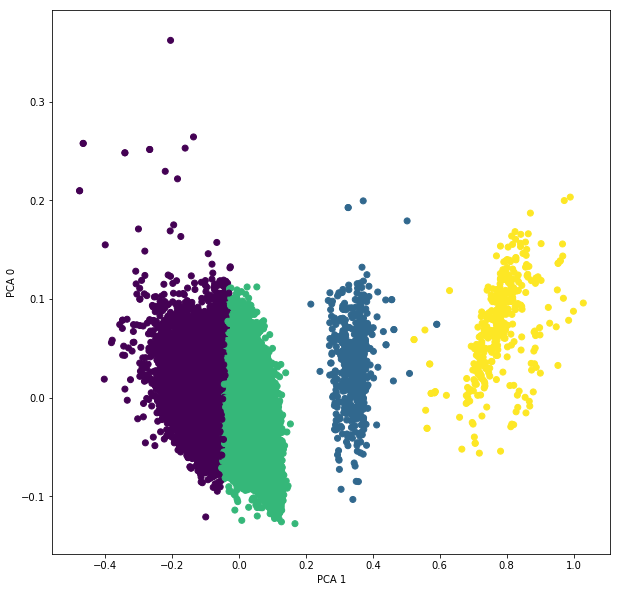

In [163]:
# Leave out categorical features for now
features2 = ['gender', 'age', 'official', 'overall_perc', 'div_perc', 'lat', 'long']

X = df[features2]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values
y_pred = KMeans(n_clusters=4).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:,0], X_pca[:, 1], c=y_pred)
plt.title('K Means')
plt.ylabel('PCA 0')
plt.xlabel('PCA 1')
plt.show()

In [ ]:
# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:,0], X_pca[:, 1], c=y_pred)
plt.ylabel('PCA 0')
plt.xlabel('PCA 1')
plt.show()

Number of estimated clusters: 10


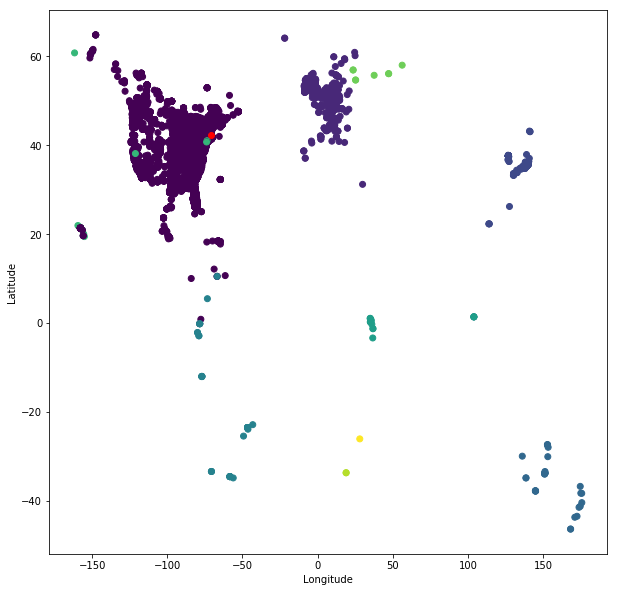

In [170]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm, quantile=0.4, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
fig = plt.figure(figsize=(10, 10))
plt.scatter(X['long'], X['lat'], c=labels)
plt.scatter(boston_long, boston_lat, c='r', label='Boston')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

# Geographic Grouping

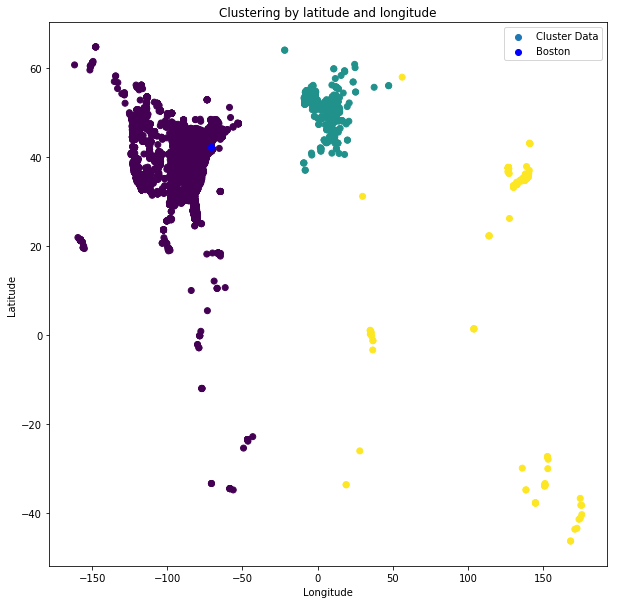

In [161]:
features_geo = ['lat', 'long']
X = df[features_geo]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)

# Calculate predicted values
y_pred = KMeans(n_clusters=3).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X['long'], X['lat'], c=y_pred, label='Cluster Data')
plt.scatter(boston_long, boston_lat, c='b', label='Boston')
plt.legend()
plt.title('Clustering by latitude and longitude')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()